In [ ]:


import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report

# 0) Reproducibility + Settings

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = r"./PlantVillage"   
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
AUTOTUNE = tf.data.AUTOTUNE

USE_CLASS_WEIGHTS = True  # helps with class imbalance 
SAVE_MODEL_PATH = "plant_disease_cnn.keras"

# 1) GPU Check (optional)

print("TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPUs found:", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPU(s).")
    except Exception as e:
        print("Could not set memory growth:", e)

# 2) Load dataset from folders

if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}")

# Load full dataset first (no split) so we can create train/val/test manually
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = full_ds.class_names
num_classes = len(class_names)
print("Classes:", num_classes)
print("Example classes:", class_names[:10])

# Convert to an unbatched dataset for splitting
full_ds_unbatched = full_ds.unbatch()

# Count total samples
card = tf.data.experimental.cardinality(full_ds_unbatched).numpy()
if card == tf.data.experimental.INFINITE_CARDINALITY or card == tf.data.experimental.UNKNOWN_CARDINALITY:
    # fallback: count manually
    card = 0
    for _ in full_ds_unbatched:
        card += 1

total_count = int(card)
print("Total images:", total_count)

test_count = int(total_count * TEST_SPLIT)
val_count = int(total_count * VAL_SPLIT)
train_count = total_count - val_count - test_count

print(f"Split sizes => train: {train_count}, val: {val_count}, test: {test_count}")

# Shuffle before split
full_ds_unbatched = full_ds_unbatched.shuffle(buffer_size=min(total_count, 10000), seed=SEED, reshuffle_each_iteration=False)

train_ds = full_ds_unbatched.take(train_count)
rest_ds = full_ds_unbatched.skip(train_count)
val_ds = rest_ds.take(val_count)
test_ds = rest_ds.skip(val_count).take(test_count)

# Re-batch
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Prefetch/caching 
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# 3) Data Augmentation + Normalization

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
        layers.RandomContrast(0.10),
    ],
    name="augmentation"
)

normalizer = layers.Rescaling(1.0 / 255.0, name="rescale")

# 4) Build a Custom CNN 
def build_custom_cnn(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = normalizer(x)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 4
    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="custom_cnn_plant_disease")

model = build_custom_cnn(input_shape=IMG_SIZE + (3,), n_classes=num_classes)
model.summary()


TensorFlow: 2.16.2
GPUs found: 1
Enabled memory growth on GPU(s).
Found 20638 files belonging to 15 classes.
Classes: 15
Example classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


2025-12-14 16:46:13.372275: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-12-14 16:46:13.372302: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-12-14 16:46:13.372311: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-12-14 16:46:13.372327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-14 16:46:13.372336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total images: 20638
Split sizes => train: 14448, val: 3095, test: 3095


2025-12-14 16:46:15.829436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "custom_cnn_plant_disease"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 459,983 (1.75 MB)

 Trainable params: 459,023 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

Class counts (train): [ 688 1029  706  705  110 1505  699 1385  674 1215 1182  997 2182  254
 1117]
Using class weights: {0: 1.4, 1: 0.936, 2: 1.364, 3: 1.366, 4: 8.756, 5: 0.64, 6: 1.378, 7: 0.695, 8: 1.429, 9: 0.793, 10: 0.815, 11: 0.966, 12: 0.441, 13: 3.792, 14: 0.862}
Epoch 1/15


2025-12-14 16:46:19.381298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-14 16:46:20.000459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


    452/Unknown 101s 214ms/step - accuracy: 0.4846 - loss: 1.6281

2025-12-14 16:48:00.224058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:48:00.224083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_74]]
2025-12-14 16:48:00.224117: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:48:00.224123: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6445014054911252352
2025-12-14 16:48:00.224127: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15305516907302502739
2025-12-14 16:48:00.224130: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 100658867

452/452 ━━━━━━━━━━━━━━━━━━━━ 107s 228ms/step - accuracy: 0.4848 - loss: 1.6273 - val_accuracy: 0.3489 - val_loss: 2.3893 - learning_rate: 0.0010
Epoch 2/15


2025-12-14 16:48:06.485428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:48:06.485446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:48:06.485456: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:48:06.485459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 16:48:06.485463: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7224 - loss: 0.8204

2025-12-14 16:49:43.048709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:49:43.048747: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8153116475534581320
2025-12-14 16:49:43.048751: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:49:43.048754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 16:49:43.048757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18114008284013241384
2025-12-14 16:49:43.048760: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9105099554129684122
2025-12-14 16:49:43.048763: I tensorflow/core/framework/local_rendezv

452/452 ━━━━━━━━━━━━━━━━━━━━ 103s 223ms/step - accuracy: 0.7224 - loss: 0.8203 - val_accuracy: 0.2562 - val_loss: 5.1049 - learning_rate: 0.0010
Epoch 3/15


2025-12-14 16:49:49.083267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:49:49.083283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:49:49.083289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:49:49.083293: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 16:49:49.083307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7828 - loss: 0.6335

2025-12-14 16:51:24.791017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:51:24.791037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8153116475534581320
2025-12-14 16:51:24.791040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 16:51:24.791044: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:51:24.791047: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18114008284013241384
2025-12-14 16:51:24.791050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/compil

452/452 ━━━━━━━━━━━━━━━━━━━━ 102s 221ms/step - accuracy: 0.7828 - loss: 0.6333 - val_accuracy: 0.3929 - val_loss: 4.1437 - learning_rate: 0.0010
Epoch 4/15


2025-12-14 16:51:30.601840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:51:30.601865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:51:30.601879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:51:30.601886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8536 - loss: 0.4354

2025-12-14 16:53:06.575704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:53:06.575721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_70]]
2025-12-14 16:53:06.575735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10267593327895134374
2025-12-14 16:53:06.575742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 16:53:06.575745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:53:06.575748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18114008284013241384
2025-12

452/452 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step - accuracy: 0.8536 - loss: 0.4354 - val_accuracy: 0.1994 - val_loss: 7.4150 - learning_rate: 5.0000e-04
Epoch 5/15


2025-12-14 16:53:13.568357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:53:13.568388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:53:13.568402: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:53:13.568406: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 16:53:13.568412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8692 - loss: 0.3774

2025-12-14 16:54:49.129642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:54:49.129664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15273370705938791912
2025-12-14 16:54:49.129677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14818224277049233908
2025-12-14 16:54:49.129681: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 16:54:49.129685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:54:49.129691: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18114008284013241384
2025-12-14 16:54:49.129698: I tensorflow/core/framework/local_rende

452/452 ━━━━━━━━━━━━━━━━━━━━ 101s 220ms/step - accuracy: 0.8692 - loss: 0.3773 - val_accuracy: 0.3926 - val_loss: 4.2872 - learning_rate: 5.0000e-04
Epoch 6/15


2025-12-14 16:54:54.929516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:54:54.929536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:54:54.929542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:54:54.929546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 16:54:54.929550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8946 - loss: 0.3118

2025-12-14 16:56:28.012094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:56:28.012119: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8153116475534581320
2025-12-14 16:56:28.012128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 16:56:28.012144: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:56:28.012156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10985853593999459248
2025-12-14 16:56:28.012158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9105099554129684122
2025-12-14 16:56:28.012161: W tensorflow/core/framework/local_rendezv

452/452 ━━━━━━━━━━━━━━━━━━━━ 99s 216ms/step - accuracy: 0.8947 - loss: 0.3117 - val_accuracy: 0.8297 - val_loss: 0.5142 - learning_rate: 2.5000e-04
Epoch 7/15


2025-12-14 16:56:33.712932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:56:33.712957: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:56:33.712962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:56:33.712975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9052 - loss: 0.2595

2025-12-14 16:58:08.403066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:58:08.403088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_34/_92]]
2025-12-14 16:58:08.403103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15305516907302502739
2025-12-14 16:58:08.403109: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2845593996424176121
2025-12-14 16:58:08.403114: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10065886789099603127
2025-12-14 16:58:08.403118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17825462

452/452 ━━━━━━━━━━━━━━━━━━━━ 100s 220ms/step - accuracy: 0.9052 - loss: 0.2595 - val_accuracy: 0.7544 - val_loss: 1.0084 - learning_rate: 2.5000e-04
Epoch 8/15


2025-12-14 16:58:14.163440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:58:14.163459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:58:14.163473: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:58:14.163481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9156 - loss: 0.2468

2025-12-14 16:59:49.056596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:59:49.056623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_12/_76]]
2025-12-14 16:59:49.056666: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 16:59:49.056672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 16:59:49.056676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18114008284013241384
2025-12-14 16:59:49.056677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15305516

452/452 ━━━━━━━━━━━━━━━━━━━━ 101s 220ms/step - accuracy: 0.9156 - loss: 0.2469 - val_accuracy: 0.7916 - val_loss: 0.7543 - learning_rate: 2.5000e-04
Epoch 9/15


2025-12-14 16:59:54.851555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 16:59:54.851574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 16:59:54.851580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 16:59:54.851584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 16:59:54.851588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9213 - loss: 0.2151

2025-12-14 17:01:30.412181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:01:30.412201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8153116475534581320
2025-12-14 17:01:30.412204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_16/_80]]
2025-12-14 17:01:30.412224: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 17:01:30.412228: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 17:01:30.412235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 109858535

452/452 ━━━━━━━━━━━━━━━━━━━━ 101s 221ms/step - accuracy: 0.9213 - loss: 0.2151 - val_accuracy: 0.7457 - val_loss: 1.0938 - learning_rate: 1.2500e-04
Epoch 10/15


2025-12-14 17:01:36.216559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:01:36.216581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:01:36.216601: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:01:36.216607: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9274 - loss: 0.2082

2025-12-14 17:03:12.986062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:03:12.986109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_36/_94]]
2025-12-14 17:03:12.986120: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12888446802197945930
2025-12-14 17:03:12.986125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 17:03:12.986128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 17:03:12.986146: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10985853

452/452 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step - accuracy: 0.9274 - loss: 0.2082 - val_accuracy: 0.8543 - val_loss: 0.4719 - learning_rate: 1.2500e-04
Epoch 11/15


2025-12-14 17:03:19.340028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:03:19.340050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:03:19.340064: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:03:19.340068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 17:03:19.340073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9283 - loss: 0.2071

2025-12-14 17:04:55.561487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:04:55.561511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8153116475534581320
2025-12-14 17:04:55.561524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 17:04:55.561528: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 17:04:55.561532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14818224277049233908
2025-12-14 17:04:55.561541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7362060693130261834
2025-12-14 17:04:55.561545: I tensorflow/core/framework/local_rendezv

452/452 ━━━━━━━━━━━━━━━━━━━━ 102s 223ms/step - accuracy: 0.9283 - loss: 0.2071 - val_accuracy: 0.7735 - val_loss: 0.9178 - learning_rate: 1.2500e-04
Epoch 12/15


2025-12-14 17:05:01.713374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:05:01.713389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:05:01.713401: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:05:01.713405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 17:05:01.713410: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9309 - loss: 0.1961

2025-12-14 17:06:38.257500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:06:38.257525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397672858557144544
2025-12-14 17:06:38.257529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14818224277049233908
2025-12-14 17:06:38.257532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_74]]
2025-12-14 17:06:38.257547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15305516907302502739
2025-12-14 17:06:38.257553: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1006588

452/452 ━━━━━━━━━━━━━━━━━━━━ 102s 223ms/step - accuracy: 0.9309 - loss: 0.1961 - val_accuracy: 0.7321 - val_loss: 1.1788 - learning_rate: 1.2500e-04
Epoch 13/15


2025-12-14 17:06:44.088286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:06:44.088306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:06:44.088311: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 17:06:44.088315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9345 - loss: 0.1791

2025-12-14 17:08:18.787823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:08:18.787852: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15273370705938791912
2025-12-14 17:08:18.787854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_68]]
2025-12-14 17:08:18.787890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14818224277049233908
2025-12-14 17:08:18.787896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1260640340715038674
2025-12-14 17:08:18.787906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-

452/452 ━━━━━━━━━━━━━━━━━━━━ 101s 220ms/step - accuracy: 0.9345 - loss: 0.1791 - val_accuracy: 0.8317 - val_loss: 0.6091 - learning_rate: 6.2500e-05
Epoch 14/15


2025-12-14 17:08:24.638569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:08:24.638587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:08:24.638594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:08:24.638598: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 17:08:24.638602: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9407 - loss: 0.1745

2025-12-14 17:09:59.719876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:09:59.719935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_12/_76]]
2025-12-14 17:09:59.719946: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290066912174738
2025-12-14 17:09:59.719955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9985165641053987464
2025-12-14 17:09:59.719957: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15305516907302502739
2025-12-14 17:09:59.719965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 20222578

452/452 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step - accuracy: 0.9407 - loss: 0.1745 - val_accuracy: 0.8536 - val_loss: 0.4656 - learning_rate: 6.2500e-05
Epoch 15/15


2025-12-14 17:10:07.426362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:10:07.426406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:10:07.426425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:10:07.426433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9452 - loss: 0.1593

2025-12-14 17:11:48.791870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:11:48.791927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_32/_90]]
2025-12-14 17:11:48.791960: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10267593327895134374
2025-12-14 17:11:48.791969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8153116475534581320
2025-12-14 17:11:48.791974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17608789622093335351
2025-12-14 17:11:48.791981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14037290

452/452 ━━━━━━━━━━━━━━━━━━━━ 107s 233ms/step - accuracy: 0.9452 - loss: 0.1593 - val_accuracy: 0.8126 - val_loss: 0.7972 - learning_rate: 6.2500e-05


2025-12-14 17:11:54.918473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:11:54.918490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:11:54.918500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:11:54.918503: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 17:11:54.918507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078


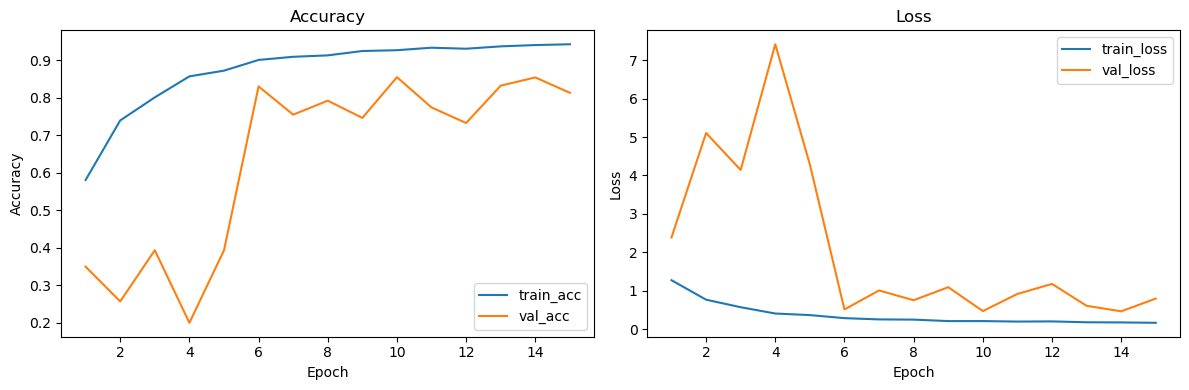

97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8558 - loss: 0.4811

Test metrics: {'loss': 0.4640132486820221, 'compile_metrics': 0.8533117771148682}


2025-12-14 17:12:01.669927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-14 17:12:01.669959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-12-14 17:12:01.669965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7803154727475970685
2025-12-14 17:12:01.669969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5390525343503130471
2025-12-14 17:12:01.669983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16191713312301736078
2025-12-14 17:12:09.188303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


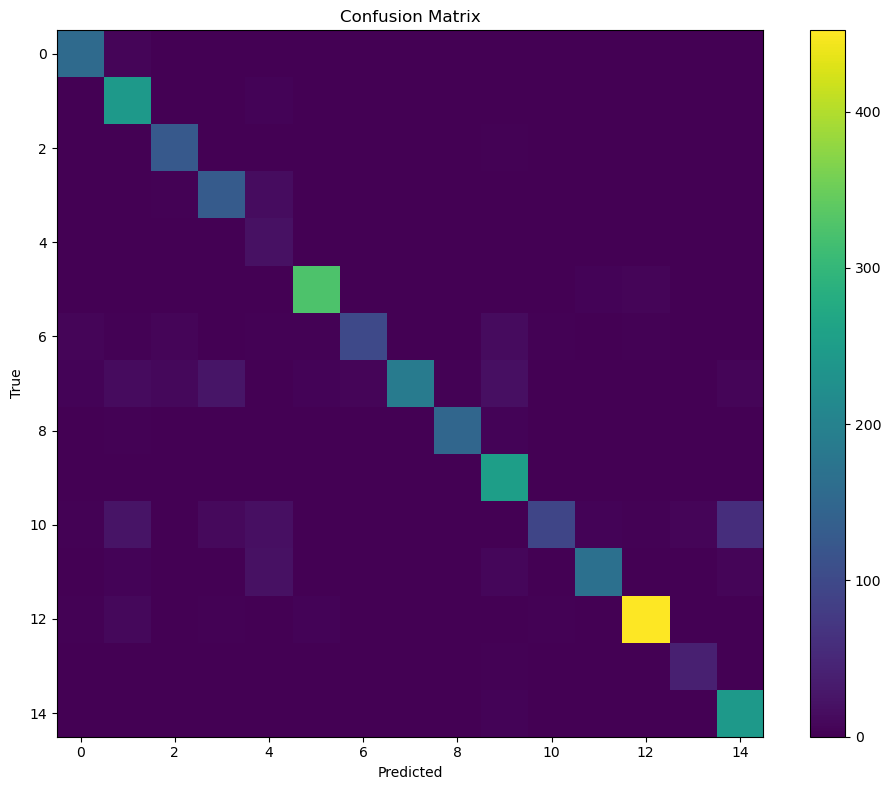


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.8971    0.9573    0.9263       164
                     Pepper__bell___healthy     0.7922    0.9799    0.8761       249
                      Potato___Early_blight     0.8581    0.9845    0.9170       129
                       Potato___Late_blight     0.7558    0.8667    0.8075       150
                           Potato___healthy     0.2500    1.0000    0.4000        21
                      Tomato_Bacterial_spot     0.9644    0.9531    0.9587       341
                        Tomato_Early_blight     0.9259    0.7092    0.8032       141
                         Tomato_Late_blight     0.9947    0.6643    0.7966       283
                           Tomato_Leaf_Mold     0.9740    0.9434    0.9585       159
                  Tomato_Septoria_leaf_spot     0.8161    0.9806    0.8908       258
Tomato_Spider_mites_Two_spotted_spider_m

In [ ]:

# 5) Compile

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]   
)



# 6) (Optional) Class Weights for imbalance

class_weight = None
if USE_CLASS_WEIGHTS:
    # Estimate label distribution from train_ds
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in train_ds:
        y_np = y.numpy()
        for c in range(num_classes):
            counts[c] += np.sum(y_np == c)

    # Avoid divide-by-zero
    counts = np.maximum(counts, 1)
    total = counts.sum()
    class_weight = {i: (total / (num_classes * counts[i])) for i in range(num_classes)}

    print("Class counts (train):", counts)
    print("Using class weights:", {k: round(v, 3) for k, v in class_weight.items()})


# 7) Callbacks

callbacks = [
    keras.callbacks.ModelCheckpoint(SAVE_MODEL_PATH, monitor="val_accuracy", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]


# 8) Train

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
)


# 9) Plot Training Curves

def plot_history(hist):
    h = hist.history
    epochs_range = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, h["accuracy"], label="train_acc")
    plt.plot(epochs_range, h["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, h["loss"], label="train_loss")
    plt.plot(epochs_range, h["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    plt.tight_layout()
    plt.show()

plot_history(history)


# 10) Evaluate on Test Set

test_metrics = model.evaluate(test_ds, verbose=1)
print("\nTest metrics:", dict(zip(model.metrics_names, test_metrics)))

# Predict labels on test set
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

y_true = np.array(y_true, dtype=np.int64)
y_pred = np.array(y_pred, dtype=np.int64)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


# 11) Grad-CAM (single image)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def show_gradcam_on_image(img_path, model, last_conv_layer_name):
    img = keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    img_array_norm = img_array / 255.0

    preds = model.predict(img_array, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    pred_name = class_names[pred_class]
    conf = float(np.max(preds[0]))

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_class)

    # Prepare overlay
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], IMG_SIZE).numpy().squeeze()
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(heatmap_resized, alpha=0.4)
    plt.title(f"Pred: {pred_name}\nConf: {conf:.3f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Find the last conv layer automatically 
last_conv = None
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv = layer.name
        break

print("\nLast conv layer for Grad-CAM:", last_conv)


print(f"\nDone. Best model saved to: {SAVE_MODEL_PATH}")


2025-12-14 18:17:59.091948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


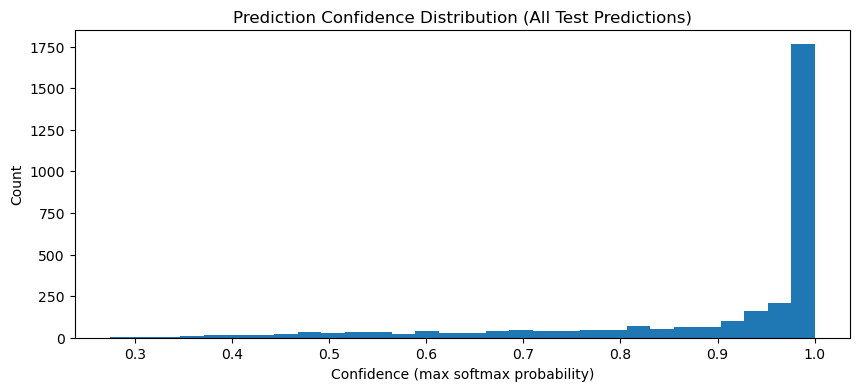

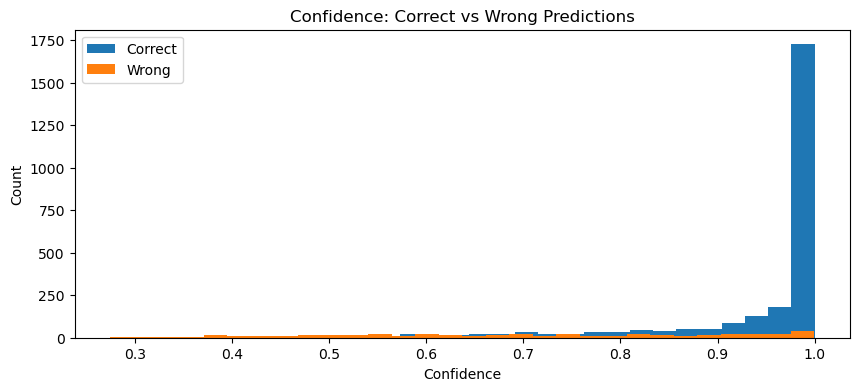

In [8]:
def plot_confidence_histogram(model, ds):
    confs = []
    correct_confs = []
    wrong_confs = []

    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        pred = np.argmax(probs, axis=1)
        conf = np.max(probs, axis=1)

        confs.extend(conf.tolist())
        for c, p, y in zip(conf, pred, yb.numpy()):
            if p == y:
                correct_confs.append(c)
            else:
                wrong_confs.append(c)

    plt.figure(figsize=(10,4))
    plt.hist(confs, bins=30)
    plt.title("Prediction Confidence Distribution (All Test Predictions)")
    plt.xlabel("Confidence (max softmax probability)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.hist(correct_confs, bins=30, label="Correct")
    plt.hist(wrong_confs, bins=30, label="Wrong")
    plt.title("Confidence: Correct vs Wrong Predictions")
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

plot_confidence_histogram(model, test_ds)


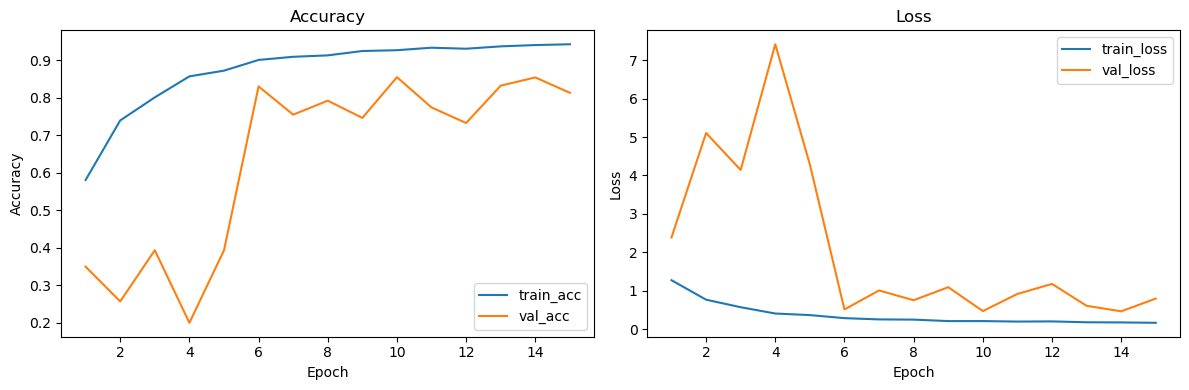

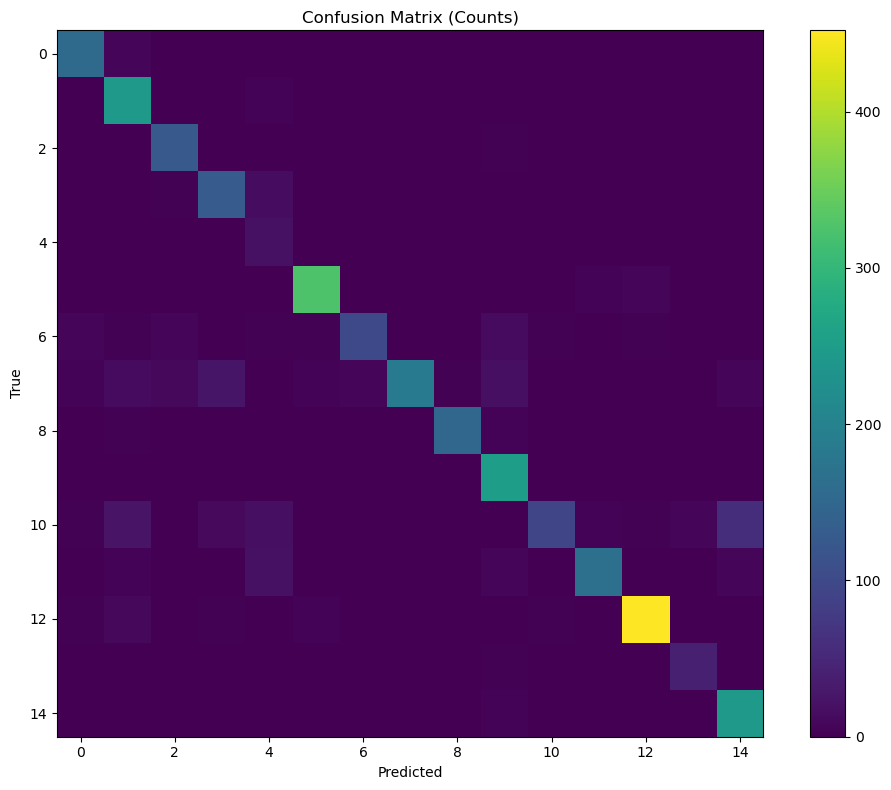

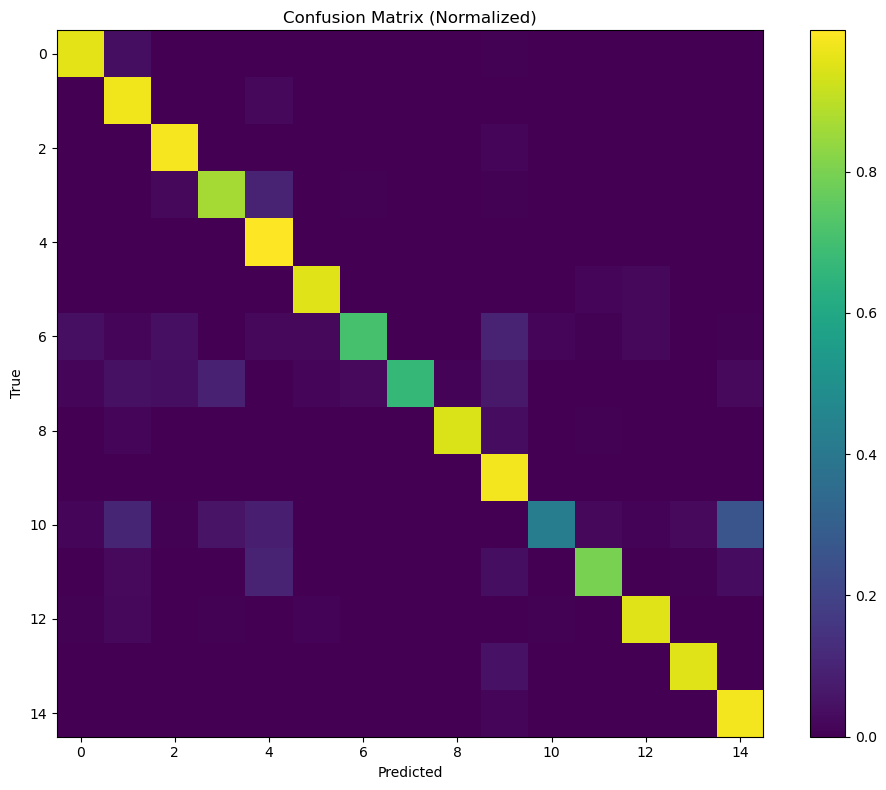

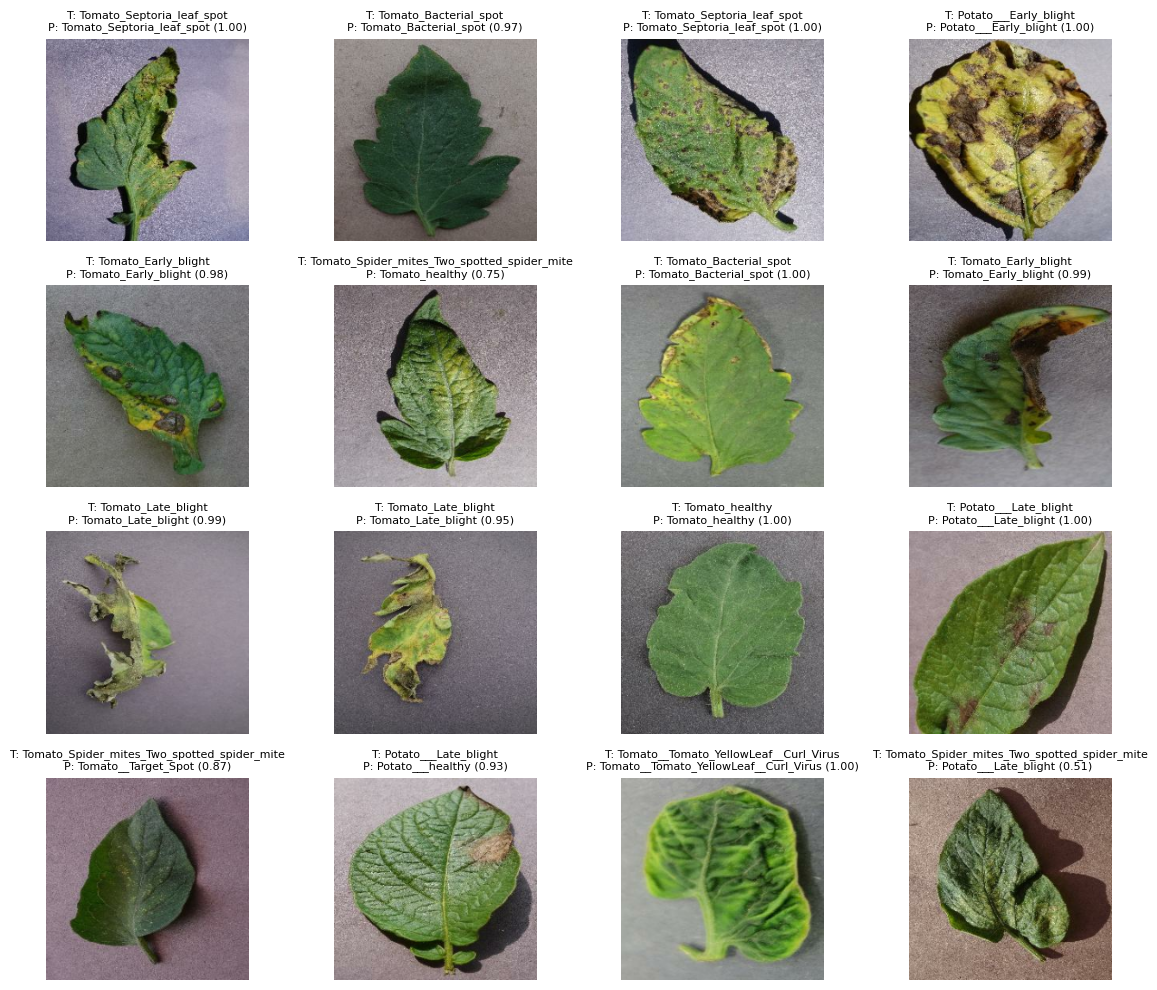

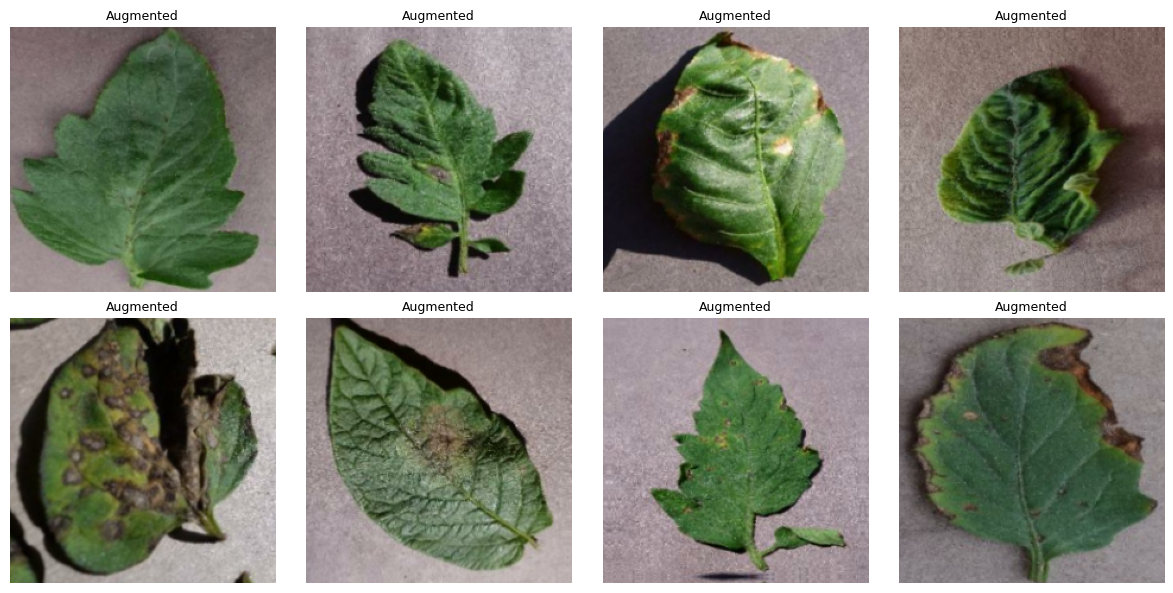

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


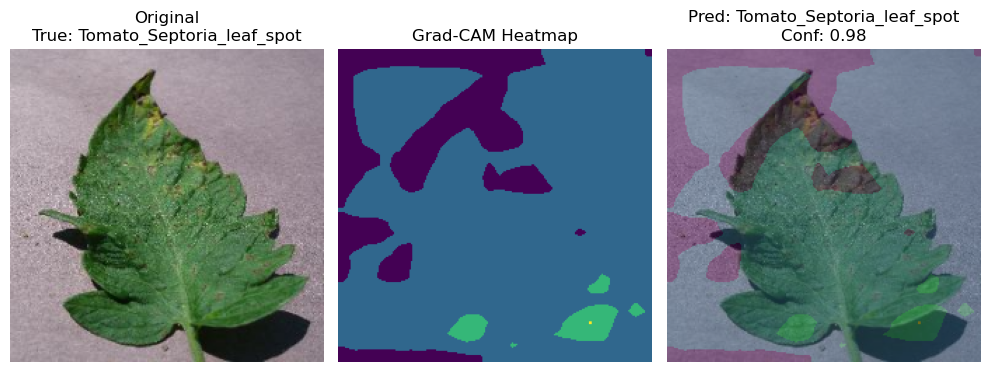


Saved report images in: report_images
Generated files:
 - fig_aug_examples.png
 - fig_confusion_matrix_counts.png
 - fig_confusion_matrix_normalized.png
 - fig_gradcam.png
 - fig_prediction_grid.png
 - fig_train_curves.png


In [9]:
# =========================================================
# 12) Save required report images (training curves, CM, pred grid, Grad-CAM, aug examples)
# =========================================================
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

OUT_DIR = "report_images"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- A) Save training curves ----------
def save_training_curves(history, out_path):
    h = history.history
    epochs_range = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, h["accuracy"], label="train_acc")
    plt.plot(epochs_range, h["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, h["loss"], label="train_loss")
    plt.plot(epochs_range, h["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

save_training_curves(history, os.path.join(OUT_DIR, "fig_train_curves.png"))


# ---------- B) Save confusion matrix (better: normalized too) ----------
def save_confusion_matrix(cm, class_names, out_path_counts, out_path_norm):
    # Counts
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(out_path_counts, dpi=200, bbox_inches="tight")
    plt.show()

    # Normalized
    cm_norm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-8)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_norm, interpolation="nearest")
    plt.title("Confusion Matrix (Normalized)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(out_path_norm, dpi=200, bbox_inches="tight")
    plt.show()

save_confusion_matrix(
    cm, class_names,
    os.path.join(OUT_DIR, "fig_confusion_matrix_counts.png"),
    os.path.join(OUT_DIR, "fig_confusion_matrix_normalized.png")
)


# ---------- C) Prediction grid (required) ----------
def save_prediction_grid(model, test_ds, class_names, out_path, n_images=16):
    # Get one batch
    for x_batch, y_batch in test_ds.take(1):
        preds = model.predict(x_batch, verbose=0)
        break

    probs = np.max(preds, axis=1)
    y_pred = np.argmax(preds, axis=1)

    n = min(n_images, x_batch.shape[0])
    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(12, 10))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        img = x_batch[i].numpy().astype("uint8")  # dataset gives uint8 images
        true_name = class_names[int(y_batch[i])]
        pred_name = class_names[int(y_pred[i])]
        conf = float(probs[i])

        ax.imshow(img)
        ax.set_title(f"T: {true_name}\nP: {pred_name} ({conf:.2f})", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

save_prediction_grid(
    model, test_ds, class_names,
    os.path.join(OUT_DIR, "fig_prediction_grid.png"),
    n_images=16
)


# ---------- D) Augmentation examples (optional but nice) ----------
def save_augmentation_examples(train_ds, augmenter, out_path, n=8):
    for x_batch, _ in train_ds.take(1):
        break
    x_batch = x_batch[:n]

    aug = augmenter(x_batch, training=True).numpy().astype("uint8")

    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(aug[i])
        ax.set_title("Augmented", fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

save_augmentation_examples(
    train_ds, data_augmentation,
    os.path.join(OUT_DIR, "fig_aug_examples.png"),
    n=8
)


# ---------- E) Grad-CAM (required) ----------
# Make sure last_conv exists
if last_conv is None:
    raise RuntimeError("Could not find a Conv2D layer for Grad-CAM.")

def save_gradcam_example(model, test_ds, class_names, last_conv_layer_name, out_path):
    # Take one image from test set
    for x_batch, y_batch in test_ds.take(1):
        img = x_batch[0].numpy()
        true_label = int(y_batch[0].numpy())
        break

    img_array = np.expand_dims(img, axis=0).astype(np.float32)

    preds = model.predict(img_array, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    pred_name = class_names[pred_class]
    conf = float(np.max(preds[0]))
    true_name = class_names[true_label]

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_class)
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], IMG_SIZE).numpy().squeeze()
    heatmap_resized = np.uint8(255 * heatmap_resized)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"Original\nTrue: {true_name}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img.astype("uint8"))
    plt.imshow(heatmap_resized, alpha=0.4)
    plt.title(f"Pred: {pred_name}\nConf: {conf:.2f}")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

save_gradcam_example(
    model, test_ds, class_names, last_conv,
    os.path.join(OUT_DIR, "fig_gradcam.png")
)

print("\nSaved report images in:", OUT_DIR)
print("Generated files:")
for f in sorted(os.listdir(OUT_DIR)):
    print(" -", f)
